In [3]:
# Import core libraries
import time
import os
import itertools
from datetime import datetime
from scipy import signal
import copy
from mne.io.pick import pick_types

# Import scientic Python librairies
import pandas as pd
import numpy as np

# Import MNE ecosystem
import mne
#from mne.io.meas_info import create_info
from mne.epochs import BaseEpochs
from mne.channels import make_standard_montage
# from mne.time_frequency import psd_welch

# Import custom functions
#import torch
#from torch.nn import CrossEntropyLoss
#from torch.optim import Adam
#from sklearn.model_selection import train_test_split
import glob
import os
import mne
import numpy as np
import matplotlib.pyplot as plt

#from model_omneeg import SleepStagerChambon2018
from torch import nn
import csv
import json
mne.set_log_level('ERROR')

# Read the demographic data of all the cohorts
#demo_HBN = pd.read_csv('/home/dubadr/projects/rrg-gdumas85/dubadr/data/hbn_demo_all.csv')
#demo_HBN = pd.read_csv('/Users/dub/PPSP/data/HBN/hbn_demo_ctr_small.csv')
#demo_HBN = pd.read_csv('/Users/dubadr/Downloads/brain2vec/Classification/hbn_demo_ctr_small.csv')
#basefolder_HBN = "/Users/dub/PPSP/data/HBN/PREPROCESSED"


In [4]:
basefolder_HBN = "/home/dubadr/scratch/2seconds/HBN/process"

# List all the participants with EEG preprocessed data
participants_HBN = sorted(list(set([f for f in os.listdir(basefolder_HBN) if os.path.isdir(os.path.join(basefolder_HBN, f))]).intersection(set(demo_HBN['id'].tolist()))))

# List of all EEG channel names
bad_chs = ['E1', 'E14', 'E17', 'E21', 'E32', 'E38', 'E43', 'E44', 'E48', 'E49', 'E56',
           'E63', 'E68', 'E73', 'E81', 'E88', 'E94', 'E99', 'E107', 'E113', 'E114', 'E119',
           'E120', 'E121', 'E125', 'E126', 'E127', 'E128']
eeg_chs = []
for n in range(1, 129):
    eeg_chs.append('E' + str(n))
eeg_chs = [ch for ch in eeg_chs if ch not in bad_chs]

# List bad HBN participants with no Eyes-open resting state
bad_participants_HBN = []

NameError: name 'demo_HBN' is not defined

In [6]:
cd /home/dubadr/projects/def-gdumas85/dubadr/OmnEEG/omneeg


/lustre06/project/6057506/dubadr/OmnEEG/omneeg


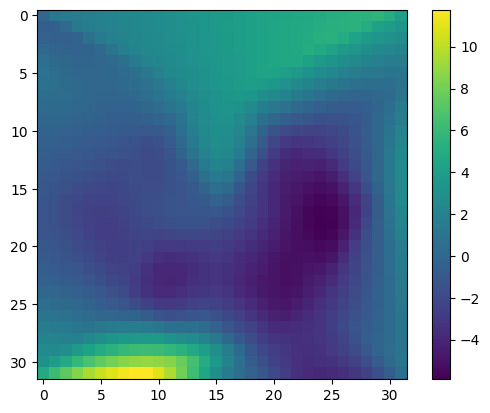

In [17]:
plt.imshow(data_temp[10,:,:,150]*1000000)
plt.colorbar()

In [5]:
import mne
from mne.channels.layout import _find_topomap_coords
from mne.viz.topomap import _adjust_meg_sphere, _GridData
import numpy as np


class Interpolate(object):
# TODO - Move on to Python3 and get rid of object inheritence
    """Interpolate a EEG to a matrix of pixels.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, eeg):
        # Check if eeg is an MNE epochs object or array-like data
        if hasattr(eeg, 'info'):
            # It's an MNE object with info attribute
            info = eeg.info
            data = eeg.get_data()
            
            # For Raw objects, reshape to epochs format (trials, channels, times)
            if isinstance(eeg, mne.io.Raw):
                data = data.reshape(1, data.shape[0], data.shape[1])  # add trial dimension
        else:
            # Assume it's a slice of epochs from an MNE object
            # This is a workaround for the error
            raise TypeError("Expected an MNE object with 'info' attribute. Please modify the io.py code.")
            
        try:
            # Try to use the standard approach first
            sphere, clip_origin = _adjust_meg_sphere(sphere=None, info=info, ch_type='eeg')
            x, y, _, radius = sphere
            # Use the public API function directly from mne
            picks = mne.pick_types(info, meg=False, eeg=True, ref_meg=False, exclude='bads')
            pos = _find_topomap_coords(info, picks, sphere=sphere)
        except RuntimeError as e:
            if "No digitization points found" in str(e):
                # Fallback: create artificial positions in a circle formation
                print("No electrode positions found, creating artificial positions")
                
                # Get number of EEG channels
                n_channels = len(picks)
                
                # Create artificial positions in a circular pattern
                radius = 0.85  # slightly smaller than unit circle for better visualization
                angles = np.linspace(0, 2*np.pi, n_channels, endpoint=False)
                x_pos = radius * np.cos(angles)
                y_pos = radius * np.sin(angles)
                
                # Create positions for all channels
                pos = np.column_stack([x_pos, y_pos])
                
                # Set default sphere and clip_origin for visualization
                sphere = (0, 0, 0, 1)  # x, y, z, radius
                clip_origin = (0, 0)
            else:
                # Re-raise other errors
                raise
            
        # Check the dimensions of data
        if not isinstance(data, np.ndarray):
            raise TypeError("Data must be a numpy array")
            
        # Ensure data has the right dimensions (epochs, channels, times)
        if len(data.shape) == 2:  # (channels, times)
            data = data.reshape(1, data.shape[0], data.shape[1])  # add epochs dimension
        elif len(data.shape) != 3:
            raise ValueError(f"Expected 2D or 3D data array, got shape {data.shape}")
            
        mask_scale = max(1.0, np.linalg.norm(pos, axis=1).max() * 1.01 / radius)
        clip_radius = (radius * mask_scale,)*2
        res = self.output_size
        image_interp = 'cubic'
        xmin, xmax = clip_origin[0] - clip_radius[0], clip_origin[0] + clip_radius[0]
        ymin, ymax = clip_origin[1] - clip_radius[1], clip_origin[1] + clip_radius[1]
        xi = np.linspace(xmin, xmax, res[0])
        yi = np.linspace(ymin, ymax, res[1])
        Xi, Yi = np.meshgrid(xi, yi)
        extrapolate = 'box'
        border = 'mean'
        interp = _GridData(pos, image_interp, extrapolate,
                          clip_origin, clip_radius, border)
                          
        print(f"Data shape: {data.shape}, Output dimensions: {res}")
        
        # Now create the output array with proper dimensions
        Z = np.zeros((data.shape[0], res[0], res[1], data.shape[2]))
        
        for epoch in range(data.shape[0]):
            for time in range(data.shape[2]):
                interp.set_values(data[epoch, :, time])
                Zi = interp.set_locations(Xi, Yi)()
                Z[epoch, :, :, time] = Zi
        return Z

In [13]:
from mne.channels.layout import _find_topomap_coords
from mne.viz.topomap import _adjust_meg_sphere, _GridData

class Interpolate(object):
    """Interpolate a EEG to a matrix of pixels.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, eeg):
        sphere, clip_origin = _adjust_meg_sphere(sphere=None, info=eeg.info, ch_type='eeg')
        print('sphere')
        x, y, _, radius = sphere
        picks = pick_types(eeg.info, meg=False, eeg=True, ref_meg=False, exclude='bads')
        print('picks')
        pos = _find_topomap_coords(eeg.info, picks, sphere=sphere)
        mask_scale = max(1.0, np.linalg.norm(pos, axis=1).max() * 1.01 / radius)
        clip_radius = (radius * mask_scale,)*2
        res = self.output_size
        print('res')
        image_interp = 'cubic'
        xlim = np.inf, -np.inf,
        ylim = np.inf, -np.inf,
        xmin, xmax = clip_origin[0] - clip_radius[0], clip_origin[0] + clip_radius[0]
        ymin, ymax = clip_origin[1] - clip_radius[1], clip_origin[1] + clip_radius[1]
        print('ymin')
        xi = np.linspace(xmin, xmax, res[0])
        yi = np.linspace(ymin, ymax, res[1])
        Xi, Yi = np.meshgrid(xi, yi)
        extrapolate = 'box'
        print('extrapolate')
        border = 'mean'
        interp = _GridData(pos, image_interp, extrapolate, clip_origin, clip_radius, border)
        
        print(interp)
        extent = (xmin, xmax, ymin, ymax)
        print(len(extrapolate))
        data = eeg.get_data()
        
        print('data')
        #data = np.mean(data, axis=2)          # shape becomes (epochs, channels)
        #data = data[:, :, np.newaxis]
        Z=np.zeros((data.shape[0], res[0], res[1], data.shape[2]))

        
        for epoch in range(data.shape[0]):

            for time in range(data.shape[2]):

                interp.set_values(data[epoch, picks, time])
                Zi = interp.set_locations(Xi, Yi)()
                Z[epoch, :, :, time] = Zi

        return Z

In [64]:
picks = pick_types(data.info, meg=False, eeg=True, ref_meg=False, exclude='bads')

In [66]:
len(picks)

127

In [ ]:
data = mne.read_epochs('/home/dubadr/scratch/TUEG/process/aaaaabls_s001_t002.edf/RestingState_epo.fif')
data_temp = Interpolate((32, 32))(data)

In [11]:
data

Number of events,0
Events,
Time range,0.000 – 1.996 s
Baseline,off


In [16]:
data_temp.shape

(428, 32, 32, 500)

In [72]:
32*32

1024

In [15]:
data_temp.get_data().shape

AttributeError: 'numpy.ndarray' object has no attribute 'get_data'

In [63]:
data.get_data().shape

(56, 128, 1001)

In [41]:
import h5py
import numpy as np

data = np.random.rand(10, 20, 30)  # example array

with h5py.File('my_data.h5', 'w') as f:
    f.create_dataset('my_array', data=data)

In [18]:
def main(database,data_folder,participant, output_folder,output_file,demo_file, reconstruction=False):
    try:
        logging.info('Attempting to get signal')
        if reconstruction:
            data_type="labels.fif"
            
        else:
            data_type='RestingState_epo.fif'

        if database == 'HBN':
            participant_id = participant
            participant_file = os.path.join(data_folder,participant,data_type)

            epochs = mne.read_epochs(participant_file,preload=True)
            
        if database =='BCAN':
            if reconstruction:
                demo = pd.read_csv(demo_file)
                basename = os.path.basename(os.path.normpath(participant))
                participant_id = basename.split('_', 1)[1] if '_' in basename else basename
                index_participant = demo[demo['Participant code'] == participant_id].index
                Record_id = demo.iloc[index_participant[0]]['Record ID']
                Participant_code = demo.iloc[index_participant[0]]['Participant code']
                participant_file = os.path.join(data_folder,str(Record_id)+'_'+str(Participant_code),data_type)
                participant_id=basename
            else:
                demo = pd.read_csv(demo_file)
                basename = os.path.basename(os.path.normpath(participant))
                participant_id = basename.split('_', 1)[1] if '_' in basename else basename
                index_participant = demo[demo['Participant code'] == participant_id].index
                Record_id = demo.iloc[index_participant[0]]['Record ID']
                Participant_code = demo.iloc[index_participant[0]]['Participant code']
                participant_file = os.path.join(data_folder,str(Record_id)+'_'+str(Participant_code),data_type)
                participant_id=basename

        if database =='VIP':
            participant_id = participant.split('.')[0]
            participant_file = os.path.join(data_folder,participant_id,data_type)

        if database =='RDB':
            participant_id = participant[:-7] 
            participant_file = os.path.join(data_folder,participant,data_type)

        if database == 'ABCCT':
            participant_id = os.path.basename(participant)
            participant_file = os.path.join(data_folder,participant,data_type)

        if database == 'XFRAGILE':
            participant_id = os.path.basename(participant)
            participant_file = os.path.join(data_folder,participant,data_type)

            participant_id = os.path.basename(participant)
            participant_file = os.path.join(data_folder,participant,data_type)
            epochs = mne.read_epochs(participant_file,preload=True)

        if database == 'NED':
            participant_id = os.path.basename(participant)
            participant_file = os.path.join(data_folder,participant,data_type)
        if database == 'HSJ':
            participant_id = os.path.basename(participant)
            participant_file = os.path.join(data_folder,participant,data_type)

        if database == 'TUEG':
            participant_id = os.path.basename(participant)
            participant_file = os.path.join(data_folder,participant,data_type)


        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="This filename (.*) does not conform to MNE naming conventions")
            epochs = mne.read_epochs(participant_file,preload=True)

        epochs.resample(500)
        df_demo = get_demo(database,data_folder,participant,demo_file)

        print('ch names')
    
        ch_names = epochs.info['ch_names']

        # Interpolate EEG
        data_temp = Interpolate((32, 32))(epochs)

        # Path to save
        h5_path = os.path.join(output_folder, participant_id + '.h5')

        # Save to HDF5
        with h5py.File(h5_path, 'w') as f:
            # Save EEG array
            f.create_dataset('power_data', data=data_temp, compression="gzip")

            # Save demographics as a group of attributes (one key per column)
            demo_group = f.create_group('demographics')
            for key, value in df_demo.iloc[0].items():  # assumes 1-row per participant
                demo_group.attrs[key] = value




    except Exception as e:
        # Print and log the full traceback, then re-raise the exception
        traceback.print_exc()
        logging.error("Exception occurred:\n" + traceback.format_exc())
        raise
    return True

class Interpolate(object):
    """Interpolate a EEG to a matrix of pixels.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, eeg):
        sphere, clip_origin = _adjust_meg_sphere(sphere=None, info=eeg.info, ch_type='eeg')
        print('sphere')
        x, y, _, radius = sphere
        picks = pick_types(eeg.info, meg=False, eeg=True, ref_meg=False, exclude='bads')
        print('picks')
        pos = _find_topomap_coords(eeg.info, picks, sphere=sphere)
        mask_scale = max(1.0, np.linalg.norm(pos, axis=1).max() * 1.01 / radius)
        clip_radius = (radius * mask_scale,)*2
        res = self.output_size
        print('res')
        image_interp = 'cubic'
        xlim = np.inf, -np.inf,
        ylim = np.inf, -np.inf,
        xmin, xmax = clip_origin[0] - clip_radius[0], clip_origin[0] + clip_radius[0]
        ymin, ymax = clip_origin[1] - clip_radius[1], clip_origin[1] + clip_radius[1]
        print('ymin')
        xi = np.linspace(xmin, xmax, res[0])
        yi = np.linspace(ymin, ymax, res[1])
        Xi, Yi = np.meshgrid(xi, yi)
        extrapolate = 'box'
        print('extrapolate')
        border = 'mean'
        interp = _GridData(pos, image_interp, extrapolate,
                           clip_origin, clip_radius, border)
        extent = (xmin, xmax, ymin, ymax)
        data = eeg.get_data()
        print('data')
        #data = np.mean(data, axis=2)          # shape becomes (epochs, channels)
        #data = data[:, :, np.newaxis]
        Z=np.zeros((data.shape[0], res[0], res[1], data.shape[2]))
        print('Z')
        
        for epoch in range(data.shape[0]):
            for time in range(data.shape[2]):
                interp.set_values(data[epoch, picks, time])
                Zi = interp.set_locations(Xi, Yi)()
                Z[epoch, :, :, time] = Zi

        return Z

In [27]:
from mne.channels.layout import _find_topomap_coords
from mne.viz.topomap import _adjust_meg_sphere, _GridData

import sys
import argparse
import logging
# Import core libraries
import time
import os
import os.path as op
import itertools
from datetime import datetime

# Import scientic Python librairies
import pandas as pd
import numpy as np
import json
# Import MNE ecosystem
import mne
from mne.channels import make_standard_montage
from mne.datasets import fetch_fsaverage
from mne.minimum_norm import make_inverse_operator, apply_inverse_epochs
from mne.datasets import eegbci
# from mne.time_frequency import psd_welch
from mne.io.pick import pick_types
from mne.viz.topomap import _adjust_meg_sphere, _GridData

from demo import get_demo
import warnings
import h5py



egi = mne.channels.make_standard_montage('GSN-HydroCel-128')

logging.basicConfig(filename='omneeg.log', filemode='w', format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.DEBUG)

import traceback

def handle_exception(exc_type, exc_value, exc_traceback):
    if issubclass(exc_type, KeyboardInterrupt):
        sys.__excepthook__(exc_type, exc_value, exc_traceback)
        return
    error_message = f"Uncaught exception: {exc_value}"
    print(error_message)
    logging.error(error_message)
    traceback_str = "".join(traceback.format_tb(exc_traceback))
    print(traceback_str)
    logging.error(traceback_str)


def trace_calls(frame, event, arg):
    if event != 'call':
        return
    co = frame.f_code
    func_name = co.co_name
    line_no = frame.f_lineno
    filename = co.co_filename
    print(f"Calling {func_name} in {filename} at line {line_no}")
    return trace_lines

def trace_lines(frame, event, arg):
    if event != 'line':
        return
    co = frame.f_code
    line_no = frame.f_lineno
    filename = co.co_filename
    print(f"Executing line {line_no} in {filename}")
    return trace_lines

#sys.settrace(trace_calls)

sys.excepthook = handle_exception

In [25]:
cd /home/dubadr/projects/def-gdumas85/dubadr/deephy/libs/Markers

/lustre06/project/6057506/dubadr/deephy/libs/Markers


In [28]:
database='TUEG'
data_folder='/home/dubadr/projects/def-gdumas85/tmp/TUEG/process'
participant='aaaaadkm_s003_t001.edf'
output_folder='/home/dubadr/projects/def-gdumas85/tmp/TUEG/omneeg'
output_file='/home/dubadr/projects/def-gdumas85/tmp/TUEG/omneeg/aaaaadkm_s003_t001.h5'
demo_file='/home/dubadr/projects/def-gdumas85/dubadr/deephy/datasets/HBN/data/hbn_demo_cat.csv'

main(database,data_folder,participant, output_folder,output_file,demo_file, reconstruction=False)

Unknown database.
ch names
sphere
picks
res
ymin
extrapolate
data
Z


/lustre06/project/6057506/dubadr/deephy/libs/Markers/demo.py:456: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_demo.fillna('unknown', inplace=True)


True